In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast
import itertools

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

%matplotlib inline

fallacies = pd.read_csv('../../data/general/arguments-en-2018-01-15.tsv', sep='\t', header=0)
fallacies=fallacies.dropna(subset=['Intended Fallacy'])

In [10]:
fallacies['fallacy'] = np.where(fallacies['Intended Fallacy']=='No Fallacy', False, True)

In [11]:
fallacies.head()

,Row number,Mongo ID,Author,Topic,Stance,Intended Fallacy,Voted Fallacy,Number of Votes,Text,fallacy
0,0,6934db0d885b3fac,bbc9da056b6a9234,Should cellphones be used during class?,contra,Appeal to Emotion,-,0.0,"No, imagine you were a teacher and everybody w...",True
1,1,ee6d7274a24775f4,a4f93c2c8cc92a8c,Has anyone been on the moon?,contra,Red Herring,-,1.0,"The moon is so far away, we should focus on ou...",True
2,2,d9fdef824f3ad0cf,3f4339e14df7d077,Is it justified to develop nuclear energy for ...,contra,Irrelevant Authority,Irrelevant Authority,6.0,"The green party in Germany has the opinion, th...",True
3,3,b72997c3180d5d7b,e01c557ce0fdb585,Do social networking sites have a positive imp...,contra,Red Herring,-,0.0,"No, not at all. Nowadays kids spend all time p...",True
4,4,6322e37dbaa299b8,d038663d70f77d9b,Should driving under the influence of alcohol ...,pro,No Fallacy,No Fallacy,8.0,"Yes, whoever drinks and drives has a bad reac...",False


In [12]:
from sklearn.model_selection import train_test_split
train, test = train_test_split( fallacies, test_size=0.3, random_state=3)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit_transform(fallacies['Intended Fallacy'].astype(str))
train['Intended Fallacy id'] = le.transform(train['Intended Fallacy'].astype(str))
test['Intended Fallacy id'] = le.transform(test['Intended Fallacy'].astype(str))

v = TfidfVectorizer()
v.fit(fallacies['Topic'].values.astype('U'))
x_train = v.transform(train['Topic'].values.astype('U'))
x_test = v.transform(test['Topic'].values.astype('U'))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [14]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0).fit(x_train, train['fallacy'])

In [15]:
train.dtypes

Row number              object
Mongo ID                object
Author                  object
Topic                   object
Stance                  object
Intended Fallacy        object
Voted Fallacy           object
Number of Votes        float64
Text                    object
fallacy                   bool
Intended Fallacy id      int64
dtype: object

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Normalized confusion matrix
[[0.13 0.28 0.06 0.09 0.38 0.06]
 [0.16 0.25 0.05 0.05 0.42 0.05]
 [0.17 0.17 0.09 0.04 0.47 0.06]
 [0.14 0.19 0.09 0.05 0.5  0.03]
 [0.07 0.22 0.05 0.01 0.62 0.03]
 [0.11 0.24 0.08 0.02 0.48 0.06]]


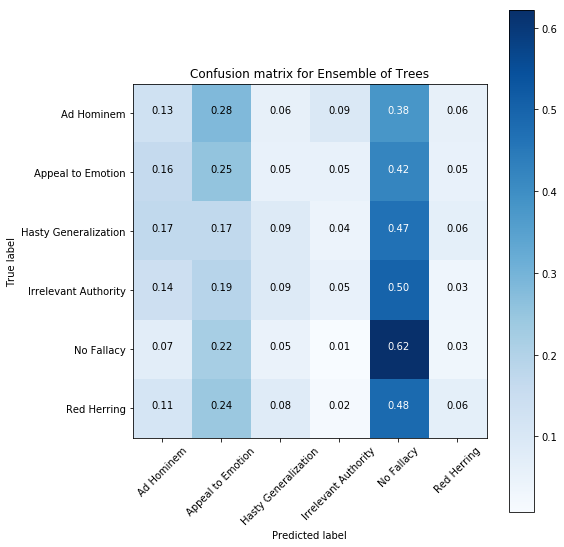

In [28]:
from sklearn.metrics import confusion_matrix
predicted = clf.predict(x_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(test['Intended Fallacy id'], predicted)

np.set_printoptions(precision=2)

#fig.savefig("plt_n.png")

# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, le.inverse_transform([0, 1, 2, 3, 4, 5]),normalize=True, 
                      title="Confusion matrix for Ensemble of Trees")



In [18]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(x_train, train['Intended Fallacy id'])

In [63]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100).fit(x_train, train['Intended Fallacy id'])

In [32]:
clf = OneVsOneClassifier(MultinomialNB()).fit(x_train, train['Intended Fallacy id'])

In [25]:
from sklearn import tree
clf = tree.DecisionTreeClassifier().fit(x_train, train['Intended Fallacy id'])

In [21]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=500).fit(x_train, train['Intended Fallacy id'])

In [27]:
from sklearn.multiclass import OneVsOneClassifier
clf = OneVsOneClassifier(tree.DecisionTreeClassifier()).fit(x_train, train['Intended Fallacy id'])